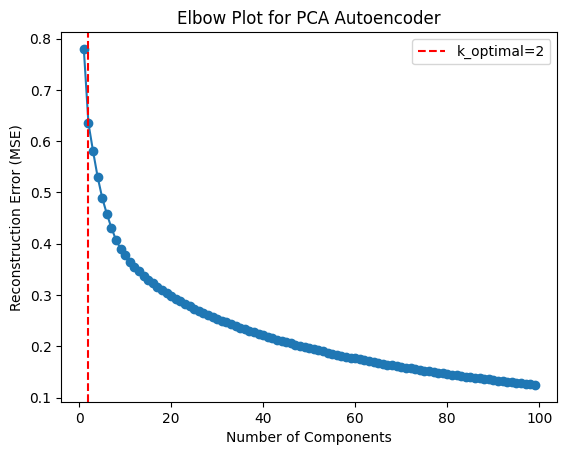

Optimal number of components (k_optimal): 2


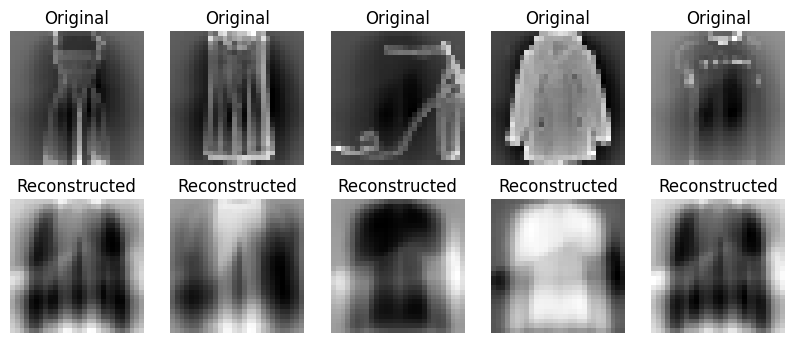

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
from PIL import Image

class PcaAutoencoder:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.pca = None

    def fit(self, X):
        """
        Fit the PCA model to the training data.
        """
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X)

    def encode(self, X):
        """
        Encode data using the PCA model.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")
        return self.pca.transform(X)

    def forward(self, X):
        """
        Reconstruct data from the encoded representation.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")
        encoded = self.encode(X)
        return self.pca.inverse_transform(encoded)

class FashionMNISTDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Separate the label from the pixel values
        label = self.data.iloc[idx, 0]
        image_array = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28)
        image = Image.fromarray(image_array, mode='L')

        if self.transform:
            image = self.transform(image)

        return image.view(-1), label  # Flatten the image to a 784-dim vector

def find_optimal_components(X_val):
    """
    Finds the optimal number of PCA components by plotting the elbow graph
    for reconstruction error vs number of components.
    """
    X_val_data = []
    for batch in X_val:
        data, _ = batch
        X_val_data.extend(data.numpy())

    X_val_data = np.array(X_val_data)
    scaler = StandardScaler()
    X_val_data = scaler.fit_transform(X_val_data)  # Standardize validation data

    reconstruction_errors = []
    n_components_range = range(1, 100)

    for n in n_components_range:
        model = PcaAutoencoder(n_components=n)
        model.fit(X_val_data)
        X_reconstructed = model.forward(X_val_data)
        mse = mean_squared_error(X_val_data, X_reconstructed)
        reconstruction_errors.append(mse)

    # Calculate the second derivative to find the "elbow" point
    second_derivative = np.diff(reconstruction_errors, n=2)
    k_optimal = np.argmax(second_derivative) + 2  # +2 to account for second diff indexing

    # Plot the elbow graph with k_optimal indicated
    plt.plot(n_components_range, reconstruction_errors, marker='o')
    plt.axvline(x=k_optimal, color='r', linestyle='--', label=f"k_optimal={k_optimal}")
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Elbow Plot for PCA Autoencoder")
    plt.legend()
    plt.show()

    return k_optimal

def visualize_reconstruction(X_test, X_reconstructed, n=5):
    """
    Visualize the original and reconstructed images side by side.
    """
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original images
        plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Original")

        # Reconstructed images
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Reconstructed")
    plt.show()

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 images to a 784-dim vector
])

# Load dataset
data = pd.read_csv('/content/fashion-mnist_train.csv')
dataset = FashionMNISTDataset(data, transform=transform)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Find the optimal number of components using the validation set
k_optimal = find_optimal_components(val_loader)
print(f"Optimal number of components (k_optimal): {k_optimal}")

# Train the PCA autoencoder with the optimal number of components
pca_autoencoder = PcaAutoencoder(n_components=k_optimal)

# Prepare training data as a single array for PCA training
X_train_data = []
for batch in train_loader:
    data, _ = batch
    X_train_data.extend(data.numpy())
X_train_data = np.array(X_train_data)

# Standardize the training data and fit the PCA model
scaler = StandardScaler()
X_train_data = scaler.fit_transform(X_train_data)
pca_autoencoder.fit(X_train_data)

# Prepare test data as a single array for reconstruction
X_test_data = []
for batch in test_loader:
    data, _ = batch
    X_test_data.extend(data.numpy())
X_test_data = np.array(X_test_data)

# Standardize the test data
X_test_data = scaler.transform(X_test_data)

# Reconstruct images from the test set
X_test_reconstructed = pca_autoencoder.forward(X_test_data)

# Visualize original and reconstructed images
visualize_reconstruction(X_test_data, X_test_reconstructed, n=5)


Second Derivative for **Elbow Detection:** This method captures where the reduction in error rate slows, marking it as the "elbow."

- **CnnAutoencoder** excels in preserving shapes because convolutional layers are effective at maintaining spatial hierarchies, which are essential for understanding structure in images.
- **MlpAutoencoder** performs well in capturing edges and borders,because it treats each pixel with equal weight initially, leading it to retain clearer outlines as it learns pixel relationships.
- **PcaAutoencoder** struggles with intricate details since it’s linear and relies on variance rather than non-linear transformations, making it less effective at reconstructing complex structures like edges or outlines.
